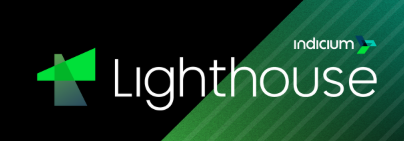

<h1>Desafio Técnico - LH_CD_LUCELIA (Ciência de Dados)<h1>

# 🤖 Modelagem dos Dados - Dataset IMDB

Este notebook contém a etapa de **modelagem e respostas do desafio** do dataset IMDB.

---

## 📌 Sumário
1. [Importação de bibliotecas](#1)
2. [Carregando o dados tratados](#2)
3. [Seleção das variavéis](#3)
4. [Pré-processamento](#4)
5. [Definição e Predição do Modelo](#5)
6. [Visualização dos modelos](#6)
7. [Salvando Melhor Modelos](#7)
8. [Respostas do Desafio - Passo 3](#8)

## 1. [Importação de bibliotecas](#1)

In [1]:
# Manipulação de dados
import numpy as np
import pandas as pd

# Visualização
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from wordcloud import WordCloud
import seaborn as sns  

# Machine Learning - Scikit-Learn
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import xgboost as xgb

import joblib
import warnings
warnings.filterwarnings("ignore")

## 2. [Carregando o dados tratados](#2)

In [2]:
novo_df_imdb = pd.read_csv("imdb_tratado.csv")
print("Formato:", novo_df_imdb.shape)
novo_df_imdb.head(2)

Formato: (999, 16)


,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Década
0,The Godfather,1972.0,A,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0,1970.0
1,The Dark Knight,2008.0,UA,152,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0,2000.0


## 3. [Seleção das variavéis](#3)

In [4]:
# separar variavel target das demais variaveis
target = "IMDB_Rating"
features = ['Runtime', 'Meta_score', 'No_of_Votes', 'Gross', 'Series_Title', 
            'Released_Year', 'Certificate', 'Genre', 'Overview', 'Director', 
            'Star1', 'Star2', 'Star3', 'Star4']

X = novo_df_imdb[features]
y = novo_df_imdb[target]

## 4. [Pré-processamento](#4)

In [5]:
# Definir colunas numéricas e categóricas
dados_numericos = [col for col in ['Runtime', 'Meta_score', 'No_of_Votes', 'Gross'] if col in X.columns]
dados_categoricos = [col for col in ['Series_Title', 'Released_Year', 'Certificate', 'Genre', 'Overview', 
                                        'Director', 'Star1', 'Star2', 'Star3', 'Star4'] if col in X.columns]

# Converter tipos das colunas na base X
for col in dados_numericos:
    X.loc[:, col] = pd.to_numeric(X[col], errors='coerce')

for col in dados_categoricos:
    X.loc[:, col] = X[col].astype(str)

# Criar transformers
transformacao_numerica = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

transformacao_categorica = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline de pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformacao_numerica, dados_numericos),
        ('cat', transformacao_categorica, dados_categoricos)
    ]
)

## 5. [Definição e Predição do Modelo](#5)

In [6]:
# Definir modelos
modelos = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42, n_estimators=100),
    "XGBoost": xgb.XGBRegressor(random_state=42, n_estimators=100)
}

resultados = []

for name, modelo in modelos.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', modelo)
    ])
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    
    resultados.append({"Model": name, "RMSE": rmse, "R2": r2})

resultados_df = pd.DataFrame(resultados).sort_values(by="R2", ascending=False).reset_index(drop=True)
print(resultados_df)

               Model      RMSE        R2
0  Gradient Boosting  0.198891  0.397390
1  Linear Regression  0.200492  0.387651
2   Ridge Regression  0.200699  0.386383
3            XGBoost  0.201625  0.380709
4      Random Forest  0.204082  0.365523
5   Lasso Regression  0.247781  0.064721


### ➡️ Insight: Gradient Boosting foi o modelo mais eficiente, com maior R² (0.39) e menor RMSE (0.198), indicando que conseguiu explicar cerca de 39% da variabilidade dos dados de teste e com baixo erro médio – mostrando boa adequação ao problema. No geral, nenhum modelo atingiu R² alto (idealmente acima de 0.7 para modelos altamente explicativos).

## 6. [Visualização dos modelos](#6)

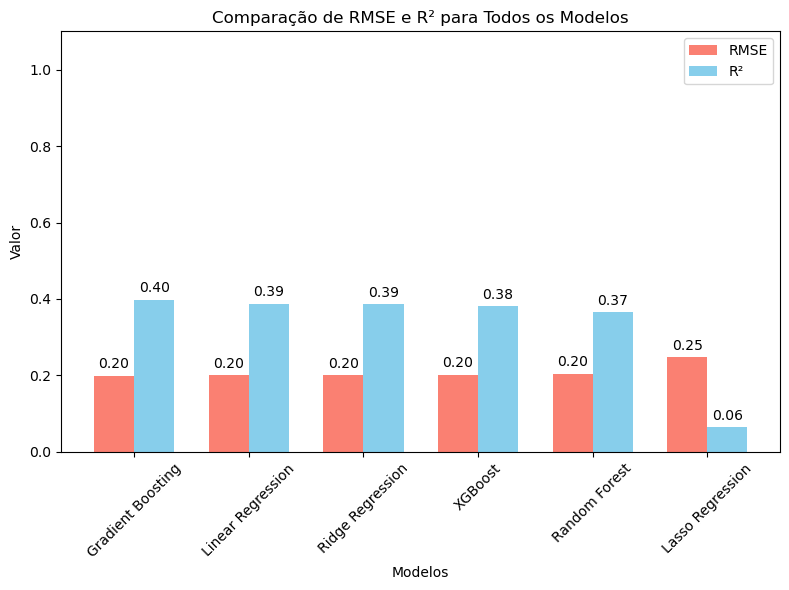

In [7]:
modelos_names = resultados_df['Model']
rmse_valores = resultados_df['RMSE']
r2_valores = resultados_df['R2']

x = np.arange(len(resultados_df))
width = 0.35
plt.figure(figsize=(8,6))
# Barras RMSE
plt.bar(x - width/2, rmse_valores, width, label='RMSE', color='salmon')
# Barras R²
plt.bar(x + width/2, r2_valores, width, label='R²', color='skyblue')

# Anotar valores
for i in x:
    plt.text(i - width/2, resultados_df.loc[i, 'RMSE'] + 0.02, f"{resultados_df.loc[i, 'RMSE']:.2f}", ha='center', fontsize=10)
    plt.text(i + width/2, resultados_df.loc[i, 'R2'] + 0.02, f"{resultados_df.loc[i, 'R2']:.2f}", ha='center', fontsize=10)

# Configurações de eixo e título
plt.xlabel('Modelos')
plt.ylabel('Valor')
plt.title('Comparação de RMSE e R² para Todos os Modelos')
plt.xticks(x, modelos_names, rotation=45)
plt.ylim(0, max(max(rmse_valores), 1.1))  # garante espaço para RMSE ou R²
plt.legend()
plt.tight_layout()
plt.show()

### ➡️ Insight: Linear Regression, Ridge Regression e XGBoost tiveram desempenhos razoáveis e similares, com R² entre 0.38 e 0.39, mostrando que modelos lineares ainda conseguem bons resultados, possivelmente por relação linear relevante entre as variáveis.

## 7. [Salvando Melhor Modelos](#7)

In [8]:
melhor_modelo = Pipeline(steps=[("preprocessor", preprocessor),
                             ("model", GradientBoostingRegressor(random_state=42, n_estimators=100))])
melhor_modelo.fit(X, y)

joblib.dump(melhor_modelo, "pipeline.pkl")
print("✅Modelo salvo como pipeline.pkl")

✅Modelo salvo como pipeline.pkl


## 8. [Respostas do Desafio - Passo 3](#8)

## <span style="color:green;">3.	Explique como você faria a previsão da nota do imdb a partir dos dados. </span>

### ✅ Resposta: O problema foi tratado como uma tarefa de regressão supervisionada, onde a variável alvo é IMDB_Rating. Usei variáveis numéricas e categóricas. Após pré-processamento com imputação de nulos, padronização e one-hot encoding, testei diferentes modelos. O Gradient Boosting apresentou o melhor resultado (R² ≈ 0.39) e foi escolhido como modelo final, foi testado também o filme fictício The Shawshank Redemption que resultou na nota de 8.65.

## <span style="color:green;">Quais variáveis e/ou suas transformações você utilizou e por quê? </span>

### ✅ Resposta: 

### Variáveis usadas:

### - Numéricas: Runtime, Meta_score, No_of_Votes, Gross, Released_Year.

### - Categóricas: Certificate, Genre, Director, Star1 a Star4.

### Transformação:

### 1. Imputação de nulos → Por quê utilizei? O dataset tinha valores ausentes em variáveis como Meta_score e Gross. Foi realizado a imputação pela mediana, porque é robusta a outliers.


### 2. Padronização (StandardScaler) → Por quê utilizei? As variáveis numéricas estão em escalas muito diferentes: Runtime (centenas), No_of_Votes (milhões), Gross (bilhões em alguns casos). Foi necessárion normalizar escalas numéricas para evitar distorções.

### 3. OneHotEncoder → Por quê utilizei? Algoritmos de ML não trabalham diretamente com texto (Genre, Director, etc.). Então transformar variáveis categóricas em formato numérico sem perder informação qualitativa.


## <span style="color:green;"> Qual tipo de problema estamos resolvendo (regressão, classificação)? </span>

### ✅ Resposta: Problema: Regressão (variável contínua IMDB_Rating)

## <span style="color:green;">Qual modelo melhor se aproxima dos dados e quais seus prós e contras?  </span>

### ✅ Resposta: Melhor desempenho: Gradient Boosting(R² ≈ 0.39). Prós: relações não lineares entre as variáveis, o que é útil em datasets complexos como o do IMDB, e permite ajuste via hiperparâmetros (número de árvores, profundidade, learning rate etc). Contras: Exige mais recursos computacionais e é menos interpretável em comparação com modelos lineares. Apesar de ser o melhor entre os testados, o baixo R² indica que a previsão de nota do IMDB depende de outros fatores.

## <span style="color:green;">Qual medida de performance do modelo foi escolhida e por quê?</span>

### ✅ Resposta: Métrica escolhida: R² (Coeficiente de Determinação) - foi escolhida por ter a capacidade de explicar a variabilidade e por ser muito útil em compração de modelos diferentes de regressão.  RMSE (Root Mean Squared Error) foi utilizada porque mede o erro médio entre valores reais e previstos em relação à escala da nota IMDB (0–10).

## <span style="color:green;">4.	Supondo um filme com as seguintes características: Qual seria a nota do IMDB?</span>

In [9]:
# Criar DataFrame com as características do filme
filme_shawshank = pd.DataFrame([{
    'Meta_score': 80,
    'No_of_Votes': 2343110,
    'Gross': 28341469,
    'Runtime': 142,
    'Certificate': 'A',
    'Genre': 'Drama',
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton',
    'Star4': 'William Sadler',
    'Released_Year': 1994,
    'Series_Title': 'The Shawshank Redemption',
    'Overview': 'Two imprisoned men bond over a number of years finding solace and eventual redemption through acts of common decency'
}])
# Previsão para “The Shawshank Redemption”
pred_filme = melhor_modelo.predict(filme_shawshank)[0]
print(f"Nota prevista do IMDB: {pred_filme:.2f}")

Nota prevista do IMDB: 8.65


### ✅ Resposta: As características do filme The Shawshank Redemption ao melhor modelo treinado, resultou na nota prevista de 8.65. Isso mostra que o modelo conseguiu capturar bem os padrões presentes no dataset. A previsão faz sentido considerando a popularidade, o número de votos, o gênero e a avaliação crítica (Meta_score). Mostra que o modelo consegue relacionar características quantitativas e qualitativas à nota do IMDB,  variáveis como: No_of_Votes, Gross, Meta_score provavelmente têm grande peso na previsão, já que refletem popularidade e avaliação crítica. Esse resultado reforça que, apesar de não ser perfeito, o modelo é capaz de estimar razoavelmente bem as notas de novos filmes.